In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [11]:
%matplotlib inline

In [3]:
!pip install --quiet astrobase

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 956 kB 47.5 MB/s 


In [4]:
import astrobase.periodbase

In [5]:
phase = lambda t, period: np.remainder(t, period)/period

In [6]:
# Data
url = 'http://www.astrouw.edu.pl/ogle/ogle4/OCVS/blg/rrlyr/phot/I/OGLE-BLG-RRLYR-01058.dat'

lcs = pd.read_csv(url, header = None, delimiter = ' ', names = ['Times', 'V', 'Errors'])
jd, mag, dmag = lcs['Times'].values, lcs['V'].values, lcs['Errors'].values

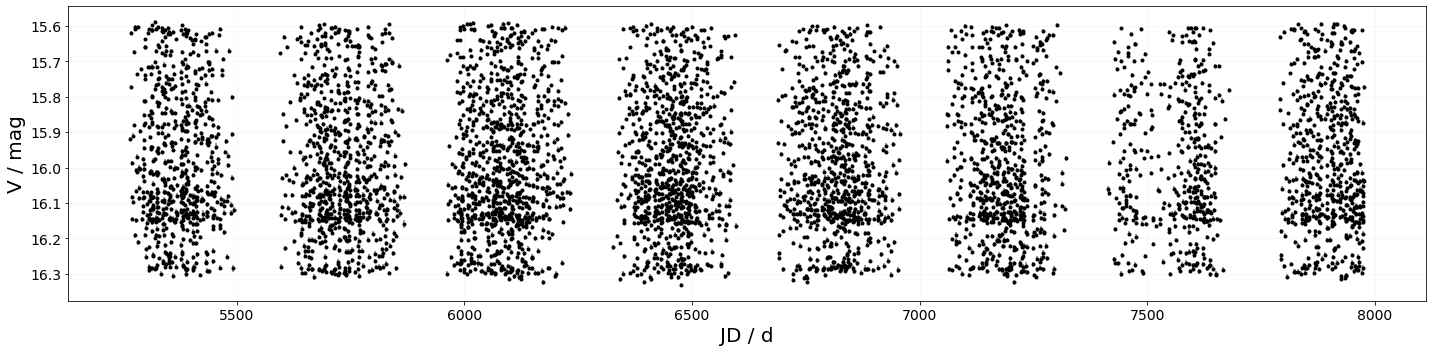

In [12]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.grid(alpha = 0.3)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

ax.invert_yaxis()
ax.grid(alpha = 0.1)

ax.set_xlabel('JD / d', fontsize = 20)
ax.set_ylabel(r'V / mag', fontsize = 20)

ax.errorbar(jd, mag, yerr = dmag, fmt = '.k', ecolor = 'grey')

plt.tight_layout()
plt.savefig('RRLyr_obs.pdf')

In [8]:
startp = 0.1
endp = 5
stepsize = 0.01
nbestpeaks = 1
periodepsilon = 0.1 

# GLS core
zgls = astrobase.periodbase.zgls.pgen_lsp(jd, mag, dmag,
                                         startp = startp, endp = endp,
                                         stepsize = stepsize,
                                         nbestpeaks = nbestpeaks, 
                                         periodepsilon = periodepsilon,
                                         nworkers = 8, verbose = True)

# Best orbital period
period = zgls['nbestperiods'][0]

In [9]:
power = zgls['lspvals']
periods = zgls['periods']

print(f'Period : {period} d')

Period : 0.5352073297834886 d


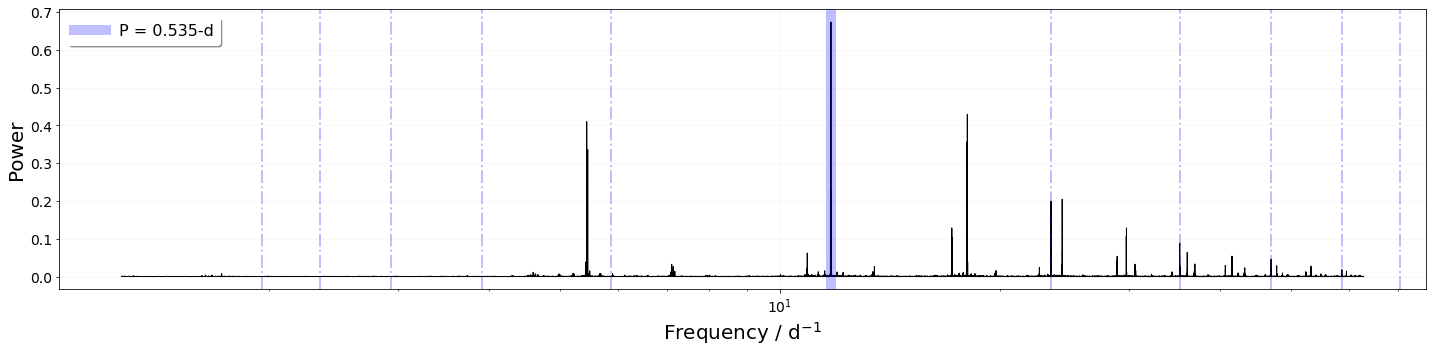

In [13]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.grid(alpha = 0.5)
ax.plot((2*np.pi)/periods, power, lw = 1.0, color = 'black')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

ax.set(xscale = 'log')
ax.grid(alpha = 0.1)

ax.set_xlabel('Frequency / d$^{-1}$', fontsize = 20)
ax.set_ylabel(r'Power', fontsize = 20)

ax.axvline((2*np.pi)/period, lw = 10.0, color = 'blue', alpha = 0.25, label = r'P = %.3f-d'%(period))

# Harmonics
for k in [2,3,4,5,6]:
  ax.axvline((2*np.pi)/(k*period), lw = 2.0, color = 'blue', ls = 'dashdot', alpha = 0.25)
  ax.axvline((2*np.pi) * k/period, lw = 2.0, color = 'blue', ls = 'dashdot', alpha = 0.25)

plt.legend(loc = 'upper left', shadow = True, edgecolor = 'white', fontsize = 16)

plt.tight_layout()
plt.savefig('RRLyr_periodogram.pdf')

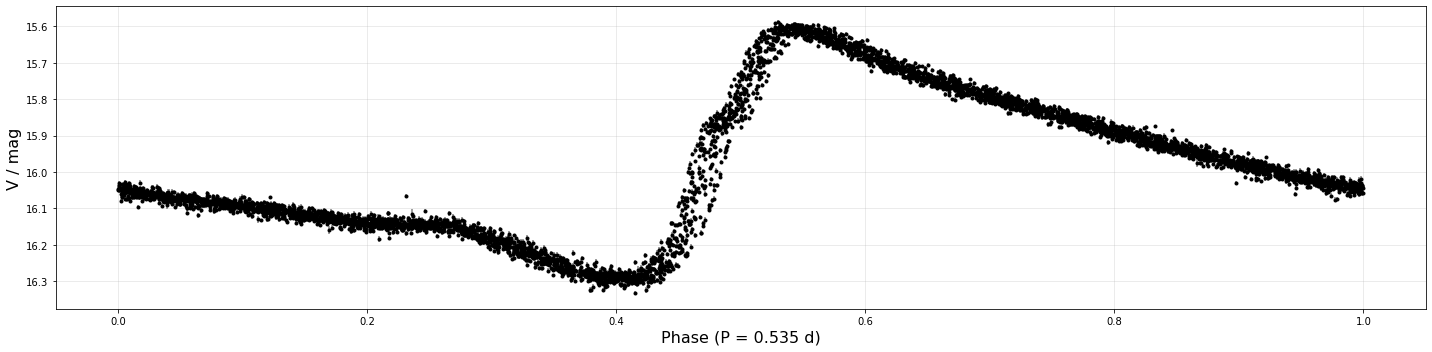

In [16]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.grid(alpha = 0.3)
ax.set_xlabel('Phase (P = %.3f d)'%(period), fontsize = 16)
ax.set_ylabel('V / mag', fontsize = 16)
ax.invert_yaxis()
ax.errorbar(phase(jd, period), mag, yerr = dmag, fmt = '.k', ecolor = 'grey')
plt.tight_layout()
plt.savefig('RRLyr_phase.pdf')

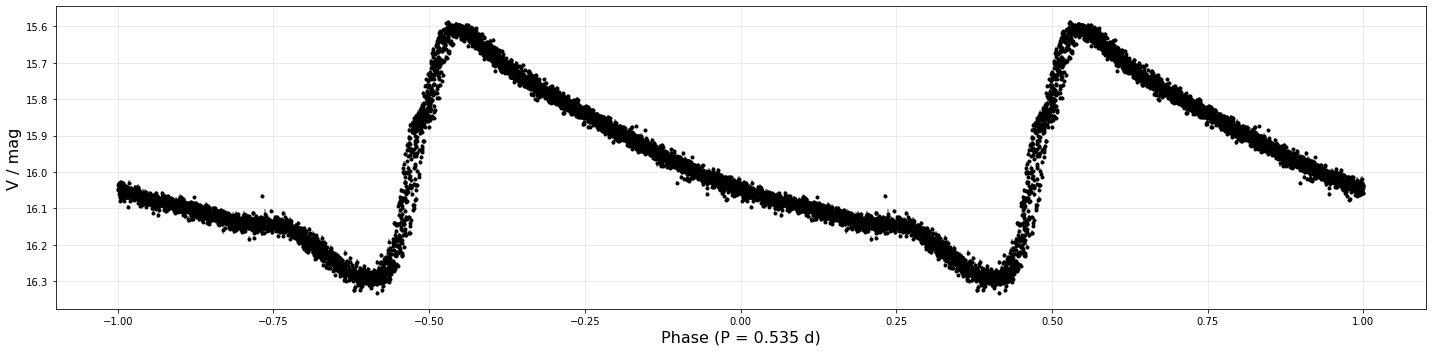

In [17]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.grid(alpha = 0.3)
ax.set_xlabel('Phase (P = %.3f d)'%(period), fontsize = 16)
ax.set_ylabel('V / mag', fontsize = 16)
ax.invert_yaxis()
ax.errorbar(np.concatenate([phase(jd, period), phase(jd, period)-1]), 
            np.concatenate([mag, mag]), yerr = np.concatenate([dmag, dmag]), fmt = '.k', ecolor = 'grey')

plt.tight_layout()

In [18]:
specwindow = astrobase.periodbase.zgls.specwindow_lsp(jd, mag, dmag, 
                                                      magsarefluxes = False, 
                                                      startp = 0.1, 
                                                      endp = 1000, 
                                                      stepsize = 1e-5, 
                                                      autofreq = False, 
                                                      nbestpeaks = 5, 
                                                      periodepsilon = 0.1, 
                                                      nworkers = 4, 
                                                      verbose = True)

swf_periods, swf_power = specwindow['periods'], specwindow['lspvals']

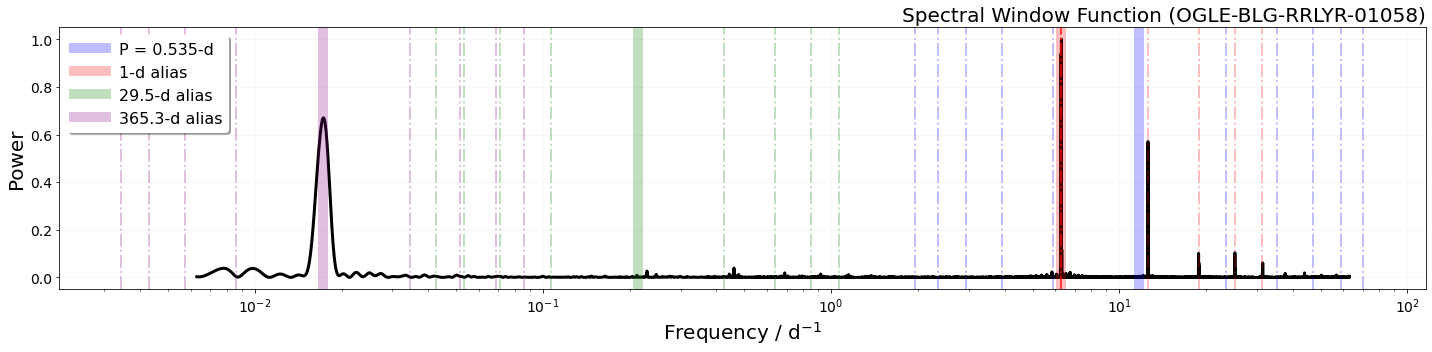

In [19]:
fig, ax = plt.subplots(figsize = (20, 5))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

ax.set(xscale = 'log')
ax.grid(alpha = 0.1)

ax.set_xlabel('Frequency / d$^{-1}$', fontsize = 20)
ax.set_ylabel(r'Power', fontsize = 20)

ax.set_title('Spectral Window Function (OGLE-BLG-RRLYR-01058)', loc = 'right', fontsize = 20)

ax.plot((2*np.pi)/specwindow['periods'], specwindow['lspvals'], lw = 3.0, color = 'black')

ax.axvline((2*np.pi)/period, lw = 10.0, color = 'blue', alpha = 0.25, label = r'P = %.3f-d'%(period))

# Harmonics
for k in [2,3,4,5,6]:
  ax.axvline((2*np.pi)/(k*period), lw = 2.0, color = 'blue', ls = 'dashdot', alpha = 0.25)
  ax.axvline((2*np.pi) * k/period, lw = 2.0, color = 'blue', ls = 'dashdot', alpha = 0.25)

ax.axvline((2*np.pi)/1, lw = 10.0, color = 'red', alpha = 0.25, label = '1-d alias')

# Harmonics (1-d alias)
for k in [2,3,4,5]:
  ax.axvline((2*np.pi)/(1), lw = 2.0, color = 'red', ls = 'dashdot', alpha = 0.25)
  ax.axvline((2*np.pi) * k, lw = 2.0, color = 'red', ls = 'dashdot', alpha = 0.25)

ax.axvline((2*np.pi)/29.5, lw = 10.0, color = 'green', alpha = 0.25, label = '29.5-d alias')

# Harmonics
for k in [2,3,4,5]:
  ax.axvline((2*np.pi)/(k*29.5), lw = 2.0, color = 'green', ls = 'dashdot', alpha = 0.25)
  ax.axvline((2*np.pi) * k/29.5, lw = 2.0, color = 'green', ls = 'dashdot', alpha = 0.25)

ax.axvline((2*np.pi)/365.3, lw = 10.0, color = 'darkmagenta', alpha = 0.25, label = '365.3-d alias')

# Harmonics
for k in [2,3,4,5]:
  ax.axvline((2*np.pi)/(k*365.3), lw = 2.0, color = 'darkmagenta', ls = 'dashdot', alpha = 0.25)
  ax.axvline((2*np.pi) * k/365.3, lw = 2.0, color = 'darkmagenta', ls = 'dashdot', alpha = 0.25)

plt.legend(loc = 'upper left', shadow = True, edgecolor = 'white', fontsize = 16)
plt.tight_layout()
plt.savefig(f'RRLyr_SWF.pdf')

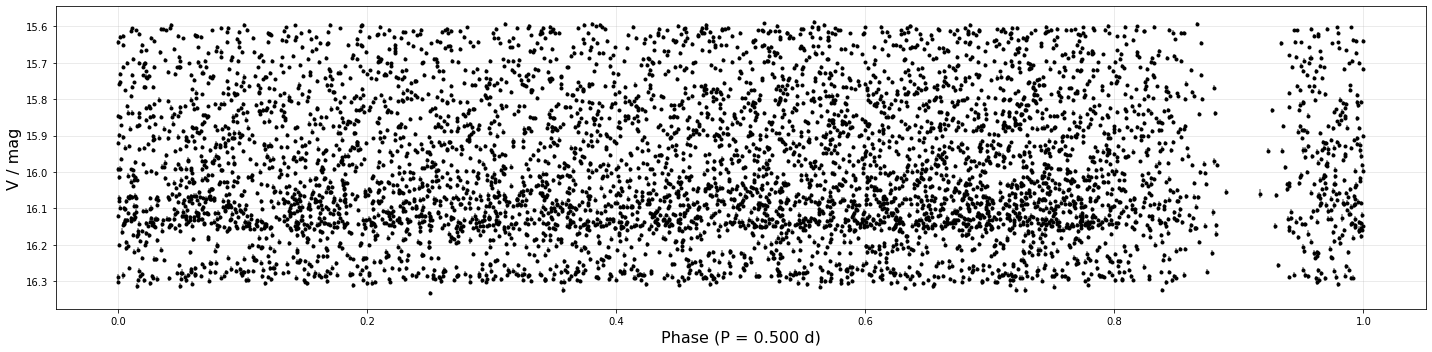

In [27]:
periodx = 0.5

fig, ax = plt.subplots(figsize = (20, 5))
ax.grid(alpha = 0.3)
ax.set_xlabel('Phase (P = %.3f d)'%(periodx), fontsize = 16)
ax.set_ylabel('V / mag', fontsize = 16)
ax.invert_yaxis()
ax.errorbar(phase(jd, periodx), mag, yerr = dmag, fmt = '.k', ecolor = 'grey')
plt.tight_layout()